In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import sys
import time

In [252]:
N_x = 10
N_y = 10
N_tot = N_x*N_y 
V = 1.
t = -V
t_prime = 0.0
U_Orig = 4. 
Doping = 0.1
T = 0.0

Periodic_Boundaries_x = True
Periodic_Boundaries_y = True

D = V
TwoBandModel = False

Magnetic_z_bias = False




np.set_printoptions(threshold=sys.maxsize,suppress=True)

In [216]:
def U_eff(q_x,q_y):
    
    return U_Orig 


def U_eff_RealSpace(x,y):
    
    INT =  integrate.dblquad(lambda q_x,q_y: np.real(U_eff(q_x,q_y)*np.exp(-1j*(q_x*x+q_y*y))),0,2*np.pi,lambda g: 0, lambda t: 2*np.pi)[0]+1j*integrate.dblquad(lambda q_x,q_y: np.imag(U_eff(q_x,q_y)*np.exp(-1j*(q_x*x+q_y*y))),0,2*np.pi,lambda g: 0, lambda t: 2*np.pi)[0]
    return INT/(2*np.pi)**2

U_Vector = []

for i in range(N_tot):
    
    x = i%N_x
    y = i//N_x
    
    U_Vector.append(U_eff_RealSpace(x,y))
U_Vector = np.array(U_Vector)

In [253]:
n_filling = 1-Doping#1 for half-filling 
beta = np.infty
print(int(N_tot*n_filling))


90


In [254]:
H_0 = np.zeros([2*N_tot,2*N_tot])#Hamiltonian without any Deltas
#GapVector = np.zeros(4*N_tot) #Contains first the n_ups, then n_downs, then Re(d_up d_down), then Im

In [255]:
QuantumNumbers = []  #To write a single index insead of (x,y,s).
for i in range(N_y):
    for j in range(N_x):
        for s in (1,-1):
            QuantumNumbers.append([j,i,s])

In [256]:
H_0 = np.zeros([2*N_tot,2*N_tot],dtype = "complex")  #Fill up H_0 without the Gaps

for i in range(2*N_tot):     
    for j in range(2*N_tot):  
        x1,y1,s1 = QuantumNumbers[i]
        x2,y2,s2 = QuantumNumbers[j]
        
        
        #Implement Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(s1 == s2 and y1 == y2):
                H_0[i,j]+= t
        
        if(y1 ==y2+1 or y1 == y2-1):
            if(s1 == s2 and x1 == x2):
                H_0[i,j]+= t
        
        
        #Implement Next-Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(y1 ==y2+1 or y1 == y2-1):
                if(s1 == s2):
                
                    H_0[i,j]+= t_prime

                
                
        if(Periodic_Boundaries_x == True): #implement boundaries
            
            #for nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
            if(x2 == 0 and x1 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
                    
        if(Periodic_Boundaries_y == True):
            
            #for nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
            if(y1 == 0 and y2 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
                    
                    
        if(Periodic_Boundaries_x == True):
            
            #For next nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1 ==y2+1 or y1 == y2-1): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                            
                            
            if(x2 == 0 and x1 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1 ==y2+1 or y1 == y2-1):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                        
        if(Periodic_Boundaries_y == True):
            
            #For next nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):  # Here without the modulus, since else we would double count the corner-corner hopping
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(y1 == 0 and y2 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
                    
                    
                    
        if(TwoBandModel == True): #implement offset if the atoms are distinct
            if(x1==x2 and y1==y2 and s1 ==s2):
                if((x1%2 == y1%2)):
                    H_0[i,j]+=D
        if(Magnetic_z_bias == True): #apply a tiny magnetic field
            if(x1 ==x2 and y1 == y2):
                if(s1==s2==1):
                    H_0 +=0.0001
            
H_0 = np.array(H_0) 

In [257]:
U_Matrix = np.zeros((N_tot,N_tot),dtype = "complex")
for i in range(N_tot):
    for j in range(N_tot):
        
        U_Matrix[i,j] = U_Vector[(N_x*(j//N_x-i//N_x)+(j%N_x-i%N_x)%N_x)%N_tot]

In [258]:
def Get_H(GapVector,H_0): #Returns the full Hamiltonian for a given GapVector
    
    H = np.array(H_0)
    
    GapVector = np.real(GapVector)
    
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    Re_up_down = GapVector[2*N_tot:3*N_tot]
    Im_up_down = GapVector[3*N_tot:4*N_tot]
    
    N_ups_new = U_Matrix@N_ups
    N_downs_new = U_Matrix@N_downs
    Re_up_down_new = U_Matrix@Re_up_down
    Im_up_down_new = U_Matrix@Im_up_down

    
    DiagonalEntries = np.append(N_downs_new,N_ups_new).reshape(2,N_tot).transpose().flatten()
    OffDiags = np.append(-Re_up_down_new+1j*Im_up_down_new,np.zeros(N_tot)).reshape(2,N_tot).transpose().flatten()[:-1]
    
    H = H + np.diag(DiagonalEntries) + np.diag(OffDiags,1) + np.diag(OffDiags.conjugate(),-1)
                  
    return np.array(H)

In [259]:
def n_occ(Energy,mu):
    return 1./(np.exp(beta*(Energy-mu))+1)

In [260]:
def Exp_Val_Matrix(Matrix,Energies,mu):
    N_Vector = n_occ(Energies,mu)

    BigM = (N_Vector*Matrix)@Matrix.transpose().conjugate()

    return BigM.transpose()
    

In [261]:
def Get_N_tot(mu,Energies):
    
    return np.sum(n_occ(Energies,mu))

In [283]:
def Next_Gap_Vector(GapVector,GetEnergy=False,ReturnBoth = False,ReturnSpectral = False,ReturnThree = False):

    H = Get_H(GapVector,H_0)
    epsilons, Eigenvectors = sp.linalg.eigh(H)
    
    
    N_filled = int(N_tot*n_filling)
    mu_initial = (epsilons[N_filled]+epsilons[N_filled-1])/2.
    
    mu = opt.root(lambda mu: Get_N_tot(mu,epsilons)-int(N_tot*n_filling),x0 = mu_initial).x[0]

    
    N_ups_new = []
    N_downs_new = []
    Re_UpDown = []
    Im_UpDown = []
    ExpValMatrix = Exp_Val_Matrix(Eigenvectors,epsilons,mu)
    for i in range(N_tot):
        N_ups_new.append(np.real(ExpValMatrix[2*i,2*i]))
        N_downs_new.append(np.real(ExpValMatrix[2*i+1,2*i+1]))
        D_up_down = ExpValMatrix[2*i,2*i+1]
        Re_UpDown.append(np.real(D_up_down))
        Im_UpDown.append(np.imag(D_up_down))

    NewGapVector = np.append(N_ups_new,np.append(N_downs_new,np.append(Re_UpDown,Im_UpDown)))
    
    
    if(GetEnergy == True):
        N_ups = GapVector[:N_tot]
        N_downs = GapVector[N_tot:2*N_tot]
        D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:4*N_tot]

        N_ups_new = U_Matrix@N_ups
        N_downs_new = U_Matrix@N_downs
        D_UpDowns_new = U_Matrix@D_UpDowns
        
        
        #To calculate the energy, Gunnarsson and Zaanen have a sign error in their very last term of eq. 2.
        #Check Energy in TD limit pls
        if(T == 0):
            Energy = sum(n_occ(epsilons,mu)*(epsilons)) - 1./2*sum(N_ups_new*N_downs)-1./2*sum(N_ups*N_downs_new) + 1./2*(sum(np.real(D_UpDowns_new)*np.real(D_UpDowns))+sum(np.imag(D_UpDowns_new)*np.imag(D_UpDowns)))+1/2*(sum(np.real(D_UpDowns)*np.real(D_UpDowns_new))+sum(np.imag(D_UpDowns)*np.imag(D_UpDowns_new)))
        else:
            Energy = -T*np.sum(np.log(1+np.exp(-beta*(epsilons-mu)))) + mu*N_filled- 1./2*sum(N_ups_new*N_downs)-1./2*sum(N_ups*N_downs_new) + 1./2*(sum(np.real(D_UpDowns_new)*np.real(D_UpDowns))+sum(np.imag(D_UpDowns_new)*np.imag(D_UpDowns)))+1/2*(sum(np.real(D_UpDowns)*np.real(D_UpDowns_new))+sum(np.imag(D_UpDowns)*np.imag(D_UpDowns_new)))
            
        if(ReturnSpectral ==True):
            return epsilons, mu
        if(ReturnBoth == True):
            return np.real(NewGapVector), np.real(Energy/int(N_tot))
        if(ReturnThree == True):
            return np.real(NewGapVector), np.real(Energy/int(N_tot)), mu
        return Energy / int(N_tot) 
    return np.real(NewGapVector)



In [284]:
def Plot_Arrows(GapVector):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    Pol = N_ups-N_downs
    Pol = Pol.reshape(N_y,N_x)
    Filling = N_ups+N_downs
    Filling = Filling.reshape(N_y,N_x)
    
    N_is = N_ups+N_downs
    Phi_is = np.angle(D_UpDowns)
    M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)
    Theta_is = np.arccos((N_ups-N_downs)/M_is)
    M_is = M_is.reshape(N_y,N_x)

    print(Theta_is[50]-np.pi/2)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    

    for i in range(N_x):
        for j in range(N_y):

            Angle = Phi_is[N_x*j+i]-Phi_is[0] +np.pi/2
            dx = 0.8*M_is.flatten()[N_x*j+i]*np.cos(Angle)
            dy = 0.8*M_is.flatten()[N_x*j+i]*np.sin(Angle)
            axes[0].arrow(i-dx/2,j-dy/2,dx,dy,head_width = 0.12)
    axes[0].set_xlabel("Spin Amplitude and Orientation")
    axes[0].set_xlim(-1,N_x)
    axes[0].set_ylim(-1,N_y)

    #print(Phi_is/np.pi)
    #print((Phi_is[1]-Phi_is[0])/(np.pi),(Phi_is[2]-Phi_is[1])/(np.pi),(Phi_is[3]-Phi_is[2])/(np.pi))
    print(np.mean(M_is.flatten()))

    im = axes[1].pcolormesh(Filling)
    axes[1].set_xlabel("Filling on each site")
    fig.tight_layout()
    #cax = fig.add_axes([0.99, 0.15, 0.02, 0.8])
    fig.colorbar(im,orientation='vertical')
    
    ###plt.savefig("N_18_20_U4_1over9Doping.pdf",format="pdf")
    plt.show()
    return Phi_is

#GapVector2 = np.load("GapVectors_NNNhopping/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_Temperature{}.npy".format(N_x,N_y,U_Orig,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y,T))
#Plot_Arrows(GapVector2)

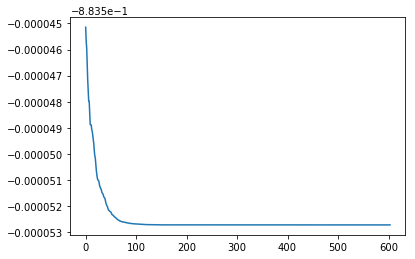

In [290]:
plt.plot(np.array(Energies)[200:])
plt.show()

In [286]:
print(max(np.abs(GapVector-Next_Gap_Vector(GapVector))))

6.195183255286452e-13


0 104.53080062178725
0.0
0.7767731034281528


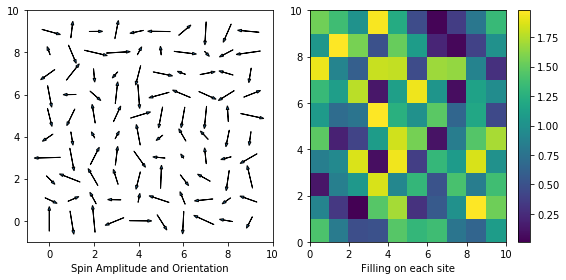

20 90.00002510262054
-9.992007221626409e-15
0.5194966429555294


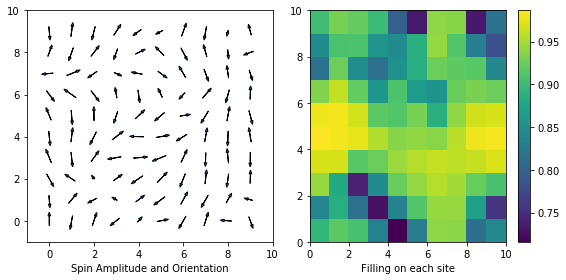

100 89.99999999999997
-1.2434497875801753e-14
0.5474215195836658


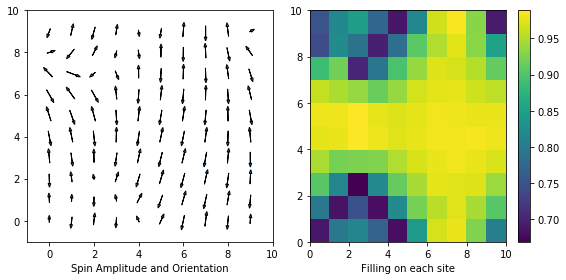

200 90.00000000000001
1.9984014443252818e-15
0.5510333565151673


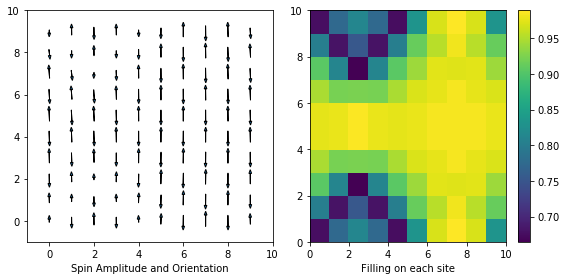

300 90.00000000000006
-9.992007221626409e-15
0.5510416280269023


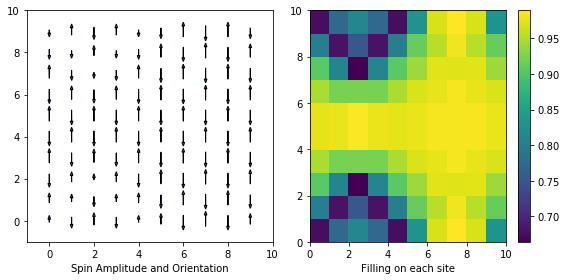

400 90.00000000000001
-6.661338147750939e-16
0.551041674985912


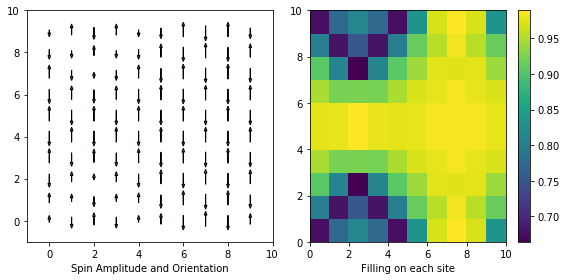

500 90.00000000000001
5.329070518200751e-15
0.5510416752141201


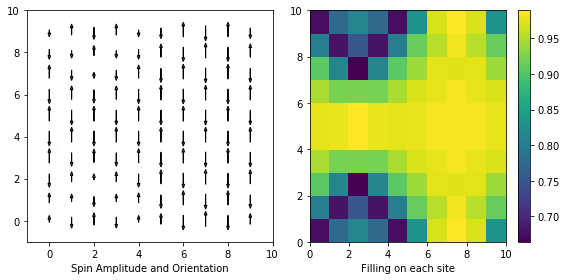

600 90.00000000000001
2.6645352591003757e-15
0.5510416752155869


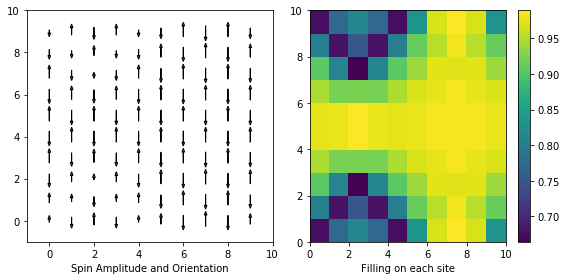

700 90.00000000000001
9.325873406851315e-15
0.5510416752155959


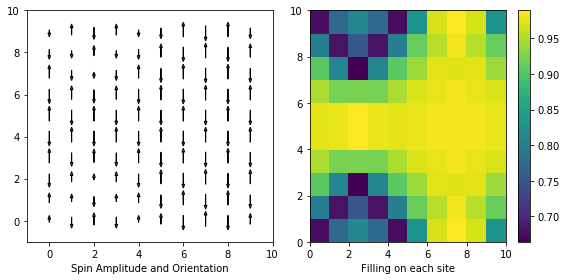

800 90.00000000000001
7.771561172376096e-15
0.5510416752155959


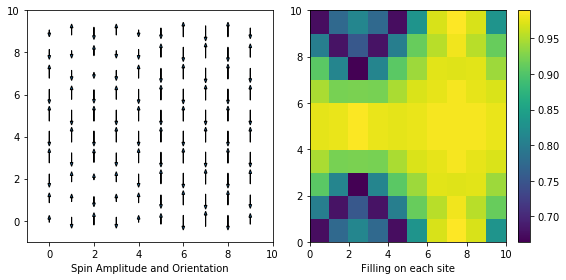

KeyboardInterrupt: 

In [288]:
###If one wants to access the energies for each iteration.

RandVec = np.random.random(N_tot)

RandVec2 = RandVec # =RandVec, if we want to enforce the polarization plane to lie in x-y-plane.

GapVector = np.append(RandVec,np.append(RandVec2,np.random.random(2*N_tot)-0.5))
mus = []
Energies = []

for i in range(100000):
    if(i%100 == 0 or i == 20):
        print(i,sum(GapVector[:2*N_tot]))
        Plot_Arrows(GapVector)
    NewGapVector,Energy,mu_new = Next_Gap_Vector(GapVector,GetEnergy = True,ReturnThree = True)
    Energies.append(Energy)
    mus.append(mu_new)
    Mixing = np.random.random()
    GapVector = Mixing*GapVector + (1-Mixing)*NewGapVector


In [ ]:
Spectral,Shift = Next_Gap_Vector(GapVector,GetEnergy = True,ReturnSpectral = True)
#print(Spectral-Shift)
plt.hist(Spectral-Shift,bins = 46)
plt.show()


In [46]:
H = Get_H(GapVector,H_0)
epsilons, Eigenvectors = sp.linalg.eigh(H)
N_filled = int(N_tot*n_filling) 
ChemPot = (epsilons[N_filled]+epsilons[N_filled-1])/2.
M= Eigenvectors
BigM = Exp_Val_Matrix(Eigenvectors,epsilons,ChemPot)

In [47]:
def CorrFunc(i1,i2,i3,i4):
    
    return BigM[i1,i4]*BigM[i2,i3]-BigM[i1,i3]*BigM[i2,i4]

In [48]:
def SpinSpinCorrFuncEqualTime(Spin_Orientation1,Spin_Orientation2,Site_Index_1,Site_Index_2): #e.g. S_1^z S_2^x
    
    #The spin orientations must be passed as a vector, e.g. z corresponds to [0,0,0,1]
    #Actually computes -1/2*(<S1S2>-<S1><S2>)

    #Define Pauli Matrices
    s0 = np.matrix([[1,0],[0,1]])
    s1 = np.matrix([[0,1],[1,0]])
    s2 = np.matrix([[0,-1j],[1j,0]])
    s3 = np.matrix([[1,0],[0,-1]])
    PauliVector = np.array([s0,s1,s2,s3])

    
    Sigma1 = np.matmul(PauliVector.transpose(),np.array(Spin_Orientation1)).transpose()/np.linalg.norm(Spin_Orientation1)
    Sigma2 = np.matmul(PauliVector.transpose(),np.array(Spin_Orientation2)).transpose()/np.linalg.norm(Spin_Orientation2)
    
    
    ExpVal = 0.
    
    for s1 in [0,1]:
        for s2 in [0,1]:
            for s3 in [0,1]:
                for s4 in [0,1]:
                    if(Site_Index_1==Site_Index_2 and s2==s3):
                        ExpVal += Sigma1[s1,s2]*Sigma2[s3,s4]*BigM[Site_Index_1+s1,Site_Index_2+s4]
                    
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*CorrFunc(2*Site_Index_1+s1,2*Site_Index_2+s3,2*Site_Index_1+s2,2*Site_Index_2+s4)
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*BigM[2*Site_Index_1+s1,2*Site_Index_1+s2]*BigM[2*Site_Index_2+s3,2*Site_Index_2+s4]
    return ExpVal

In [49]:
def CorrFuncFrequencyFast(i1,i2,i3,i4,Vectorized = False):
    if(Vectorized == False):
        Summe = -(M[i1,:].conjugate()*M[i4,:])@B@(M[i3,:].conjugate()*M[i2,:])
        return Summe

    Summe = -np.einsum('ji,ji->j',((M[i1,:].conjugate()*M[i4,:])@B),(M[i3,:].conjugate()*M[i2,:]))
    return Summe

In [50]:
def CorrFuncFrequencyFast2(i1,i2,i3,i4,Vectorized = False):
    if(Vectorized == False):
        Summe = -QuickM[i1,i4]@Contracted_M[i3,i2]
        return Summe

    Summe = -np.einsum('ji,ji->j',QuickM[i1,i4],Contracted_M[i3,i2])
    return Summe

In [51]:
def Fill_B(a,b):
    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)

    return (n_occ(epsilons[l1],ChemPot)-n_occ(epsilons[l2],ChemPot))/(epsilons[l1] -epsilons[l2]+1j*Omega)


def Fill_B_Omega0(a,b):
    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)
    
    return np.where(np.isclose(epsilons[l1],epsilons[l2]),-beta*np.exp(beta*(epsilons[l1]-ChemPot))/(np.exp(beta*(epsilons[l1]-ChemPot))+1)**2,(n_occ(epsilons[l1],ChemPot)-n_occ(epsilons[l2],ChemPot))/(epsilons[l1] -epsilons[l2]+1j*Omega))


In [52]:
Omega = 1.

B = np.zeros((2*N_tot,2*N_tot),dtype ="complex")

if(Omega != 0):
    B = np.fromfunction(Fill_B,(2*N_tot,2*N_tot),dtype = "complex")


if(Omega == 0.):
    #This usually throws an error, but I double-checked and its fiiiine
    
    B = np.fromfunction(Fill_B_Omega0,(2*N_tot,2*N_tot),dtype = "complex")


In [53]:
Contracted_M = np.fromfunction(lambda i1, i2: M[np.real(i1).astype(int),:].conjugate()*M[np.real(i2).astype(int),:],(2*N_tot,2*N_tot),dtype = object)

In [54]:
QuickM = []
for i in range(2*N_tot):
    print(i)
    for j in range(2*N_tot):
        QuickM.append(Contracted_M[i,j]@B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
QuickM = np.array(QuickM).reshape(2*N_tot,2*N_tot,2*N_tot)

In [61]:
def SpinSpinCorrFuncFrequency(Spin_Orientation1,Spin_Orientation2,Site_Index_1,Site_Index_2,Vectorized = False): #e.g. S_1^z S_2^x
    
    #The spin orientations must be passed as a vector, e.g. z corresponds to [0,0,0,1]  
    #Actually computes -1/2*(<S1S2>-<S1><S2>)
    #Define Pauli Matrices
    
    s0 = np.matrix([[1,0],[0,1]])
    s1 = np.matrix([[0,1],[1,0]])
    s2 = np.matrix([[0,-1j],[1j,0]])
    s3 = np.matrix([[1,0],[0,-1]])
    PauliVector = np.array([s0,s1,s2,s3])
    

    


    
    Sigma1 = (np.matmul(PauliVector.transpose(),np.array(Spin_Orientation1))/np.linalg.norm(Spin_Orientation1,axis = 0)).transpose()
    Sigma2 = (np.matmul(PauliVector.transpose(),np.array(Spin_Orientation2))/np.linalg.norm(Spin_Orientation2,axis = 0)).transpose()
    
    ExpVal = 0.
    
    if(Vectorized == True):
        for s1 in [0,1]:
            for s2 in [0,1]:
                for s3 in [0,1]:
                    for s4 in [0,1]:      
                        ExpVal -= Sigma1[:,s1,s2]*Sigma2[:,s3,s4]*CorrFuncFrequencyFast2(2*Site_Index_1+s1,2*Site_Index_1+s2,2*Site_Index_2+s3,2*Site_Index_2+s4,Vectorized)
        return ExpVal
    
    for s1 in [0,1]:
        for s2 in [0,1]:
            for s3 in [0,1]:
                for s4 in [0,1]:      
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*CorrFuncFrequencyFast(2*Site_Index_1+s1,2*Site_Index_1+s2,2*Site_Index_2+s3,2*Site_Index_2+s4)
    
    return ExpVal

In [62]:
def CorrFunc_Momentum_Frequency(Dir1,Dir2,Q=np.array([0.,0.]),Vectorized = False):
    #Calculates the spin-spin correlation function in two arbitrary directions in frequency- and momentum space
    Sum = 0
    print("DONT USE ME")
    Q = np.array(Q)
    for i in range(N_tot):
        Site_1 = 47 #some arbitrary site
        x1,y1 = QuantumNumbers[2*Site_1][:2]
        Site_2 = i
        x2,y2 = QuantumNumbers[2*Site_2][:2]
        Delta = np.array([x2-x1,y2-y1])
        Sum += SpinSpinCorrFuncFrequency(Dir1,Dir2,Site_1,Site_2,Vectorized)*np.exp(1j*Q@Delta)
    
    return Sum


In [63]:
Phi = np.angle(GapVector[2*N_tot]+1j*GapVector[3*N_tot])
x_Dir = [0,np.cos(Phi),np.sin(Phi),0]
y_Dir = [0,-np.sin(Phi),np.cos(Phi),0]
z_Dir = [0,0,0,1]
Chaaarge = [1,0,0,0]
DirectionArray = np.array([Chaaarge,x_Dir,y_Dir,z_Dir])

In [64]:
def Fill_Chi_0(a,b):
    
    Shape = a.shape
    a = np.array(a).flatten()
    b = np.array(b).flatten()

    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)
    
    
    Spin_Orientation1 = DirectionArray[l1%4]
    Spin_Orientation2 = DirectionArray[l2%4]

    Site_Index_1 = l1//4
    Site_Index_2 = l2//4
    
    return SpinSpinCorrFuncFrequency(Spin_Orientation1.transpose(),Spin_Orientation2.transpose(),Site_Index_1,Site_Index_2,Vectorized = True).reshape(Shape)

#Assuming translation invariance, we can only calculate Chi_0 with a fixed i component
Chi_0 = []
for i in range(4*N_tot//100): #N_tot must be divisible by 100!
    print(i)
    a,b = np.meshgrid(i*100 + np.array(range(100)),np.array(range(4*N_tot)),indexing = "ij")
    Chi_0.append(-1./2*Fill_Chi_0(a,b))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [65]:
Chi_0 = np.array(Chi_0).reshape(4*N_tot,4*N_tot)

In [66]:
Gamma = np.zeros([4*N_tot,4*N_tot],dtype = "complex")
for i in range(4*N_tot):
    for j in range(4*N_tot):
        if(i == j):
            if(i%4 == 0):
                Gamma[i,j] -= U
            else:
                Gamma[i,j] += U

In [68]:
epsilon = 0.0001
#Chi_0_Compressed_Omega0 = Chi_0_Compressed
if(Omega != 0):
    Chi = sp.linalg.inv(np.eye(4*N_tot)-Chi_0@Gamma)@Chi_0
    
if(Omega == 0):
    Chi = sp.linalg.inv(np.eye(4*N_tot)-Chi_0@Gamma*(1+epsilon))@Chi_0


In [75]:
Sum = 0
Q = np.array([np.pi,0])
Chi_Full_MomentumSpace = np.zeros((4,4),dtype = "complex")
for alpha_index in range(4):
    for beta_index in range(4):#dont write only beta, dumbass. Thats the inverse temperature
        Sum = 0
        for i in range(N_tot):
            Site_1 = 1
            x1,y1 = QuantumNumbers[2*Site_1][:2]
            Site_2 = i
            x2,y2 = QuantumNumbers[2*Site_2][:2]
            Delta = np.array([x2-x1,y2-y1])
            Sum += (Chi[alpha_index+4*Site_1,beta_index+4*Site_2]*np.exp(1j*Q@Delta))
        Chi_Full_MomentumSpace[alpha_index,beta_index] = Sum

print(np.real(Chi_Full_MomentumSpace))

[[ 0.10672832 -0.00534437  0.00388318 -0.        ]
 [-0.00542714  0.22894938  0.00700133  0.02823748]
 [ 0.00394332  0.00700135  0.23349806  0.03886284]
 [ 0.         -0.02772273 -0.03815442  0.23411025]]


In [35]:
np.save("GapVectors_NNNhopping/GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_Temperature{}.npy".format(N_x,N_y,U_Orig,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y,T),GapVector)